In [3]:
import os, sys, glob
import shutil, shlex
import subprocess
import multiprocessing
import math
import warnings
import numpy as np
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
import matplotlib as mpl
mpl.use('Agg')
from sklearn import mixture
from scipy import linalg
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
from itertools import cycle
from collections import Counter
from collections import deque
from collections import defaultdict

plt.style.use('ggplot')
sns.set_style("whitegrid")

def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False
    
def argmax(d):
    return max(d, key=(lambda x : d[x]))

def argmin(d):
    return min(d, key=(lambda x : d[x]))

/n/fs/ragr-code/general/virtualenv-python2.7/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
snvs = defaultdict(lambda : defaultdict(lambda : defaultdict(lambda : dict())))
form = (lambda L : frozenset((int(L[x-2]), int(L[x-1]), float(i)) for x, i in enumerate(L) if x%3==2))
for filename in glob.glob("../data/tracerx_lung/*.capped4.input.tsv"):
    pat = os.path.basename(filename).rstrip(".capped4.input.tsv")
    # print pat
    states = defaultdict(lambda : dict())
    with open(filename) as f:
        for l in (l for l in f if len(l) > 1 and '#' not in l):
            s = l.rstrip("\n").split("\t")
            char = int(s[2])
            ref = int(s[4])
            var = int(s[5])
            sample = int(s[0])

            state = form(s[6:])
            if state not in states[sample]:
                states[sample][state] = len(states[sample])
            snvs[pat][char][sample]['cn_states'] = state
            snvs[pat][char][sample]['cn_map'] = states[sample][state]
            snvs[pat][char][sample]['var'] = var
            snvs[pat][char][sample]['ref'] = ref
            snvs[pat][char][sample]['vaf'] = float(var) / (var + ref)
    # print [len(states[p]) for p in states]

snvs = {pat : {cidx : {sidx : snvs[pat][cidx][sidx] for sidx in snvs[pat][cidx]} for cidx in snvs[pat]} for pat in snvs}

In [5]:
globmap = defaultdict(lambda : dict())
globstates = defaultdict(lambda : dict())

for pat in snvs:
    for char in snvs[pat]:
        gstate = '_'.join(map(str, [snvs[pat][char][p]['cn_map'] for p in sorted(snvs[pat][char])]))
        if gstate not in globstates[pat]:
            globstates[pat][gstate] = len(globstates[pat])
        globmap[pat][char] = globstates[pat][gstate]
        
for pat in globstates:
    assert set(globstates[pat].values()) == set(range(max(globstates[pat].values()) + 1)), sorted(globstates[pat].values())

In [30]:
def cluster(data, maxclus=20, bayesian=False):
    if not bayesian:
        bic = []
        sol = []
        for n_components in xrange(1, min(maxclus, len(data))):
            gmm = mixture.GaussianMixture(n_components=n_components, covariance_type='diag')
            gmm.fit(data)
            bic.append(gmm.bic(data))
            sol.append(gmm)
        return sol[min(xrange(len(bic)), key=(lambda x : bic[x]))].predict(data)
    else:
        gmm = mixture.BayesianGaussianMixture(n_components=maxclus, covariance_type='diag')
        gmm.fit(data)
        return gmm.predict(data)

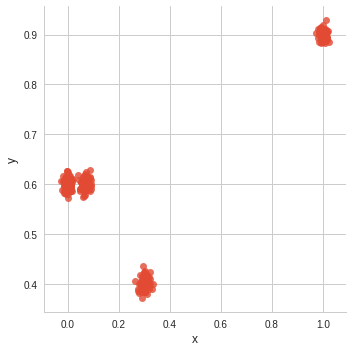

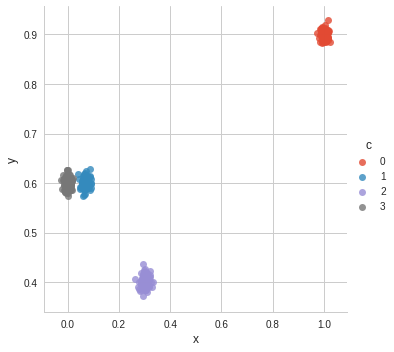

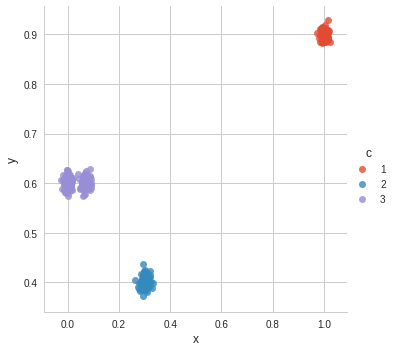

In [20]:
pnts = [{'x':np.random.normal(p[0], 0.01), 'y':np.random.normal(p[1], 0.01)} for p in [(0.3, 0.4), (0.0, 0.6), (0.07, 0.6), (1.0, 0.9)] for x in xrange(100)]
sns.lmplot(data=pd.DataFrame(pnts), x='x', y='y', fit_reg=False)

clus=cluster(np.array([[p['x'], p['y']] for p in pnts]))
df = [{'x':p['x'], 'y':p['y'], 'c':clus[x]} for x,p in enumerate(pnts)]
sns.lmplot(data=pd.DataFrame(df), x='x', y='y',hue='c', fit_reg=False)

clus=cluster(np.array([[p['x'], p['y']] for p in pnts]), bayesian=True)
df = [{'x':p['x'], 'y':p['y'], 'c':clus[x]} for x,p in enumerate(pnts)]
sns.lmplot(data=pd.DataFrame(df), x='x', y='y',hue='c', fit_reg=False)

In [32]:
final = defaultdict(lambda : dict())
for pat in globstates:
    for state in globstates[pat]:
        samples = sorted(set(p for c in snvs[pat] for p in snvs[pat][c]))
        mstate = globstates[pat][state]
        sel = [c for c in sorted(globmap[pat]) if mstate == globmap[pat][c]]
        if len(sel) > 1:
            data = [[snvs[pat][c][p]['vaf'] for p in samples] for c in sel]
            assert len(set(len(p) for p in data)) == 1, data
            clus = cluster(np.array(data), maxclus=20)
        else:
            clus = [0]
        for x, c in enumerate(sel):
            final[pat][c] = '{}_{}'.format(mstate, clus[x])

/n/fs/ragr-code/general/virtualenv-python2.7/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return_n_iter=True)
/n/fs/ragr-code/general/virtualenv-python2.7/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  return_n_iter=True)
/n/fs/ragr-code/general/virtualenv-python2.7/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return_n_iter=True)
/n/fs/ragr-code/general/virtualenv-python2.7/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  

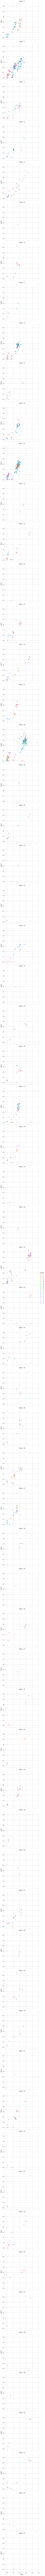

In [37]:
pat = 'CRUK0031'
p = 0
q = 1
df = []
for c in snvs[pat]:
    df.append({'Sample1' : p, 'VAF1' : snvs[pat][c][p]['vaf'], 'Sample2' : q, 'VAF2' : snvs[pat][c][q]['vaf'], 'State' : globmap[pat][c], 'Cluster' : final[pat][c].split('_')[1]})

sns.lmplot(data=pd.DataFrame(df), x='VAF1', y='VAF2', row='State', hue='Cluster', fit_reg=False)